## Drug Molecule Generation with VAE



## Introduction
In this example, we use a Variational Autoencoder to generate molecules for drug discovery.
In this example, we use a Variational Autoencoder to generate molecules for drug discovery.
Variational Autoencoder (VAE) is a type of generative model that is used for unsupervised learning. It consists of an encoder network that learns to map input data to a lower-dimensional latent space and a decoder network that generates new data by mapping points in the latent space to the original data space.![intro](https://bit.ly/3CtPMzM)


## Setup
 RDKit is used to conviently
and efficiently transform SMILES to molecule objects, and then from those obtain sets of atoms
and bonds.


In [8]:
!pip -q install rdkit-pypi==2021.9.4 --user

In [2]:
from rdkit import Chem

mol = Chem.MolFromSmiles('c1ccccc1')
print(mol)

In [1]:
import ast

import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt
from rdkit import Chem, RDLogger
from rdkit.Chem.Draw import MolsToGridImage

RDLogger.DisableLog("rdApp.*")

## Dataset



In [2]:
df = pd.read_csv("acetylcholinesterase_10_bioactivity_data_raw.csv")


In [3]:
column = df['canonical_smiles']

with open('vaetxt.txt', 'w') as file:
    column.to_csv(file, index=False, header=False)

QED (Qualitative Estimate of Drug-likeness). QED calculates a score between 0 and 1, with higher scores indicating a greater likelihood of a molecule having drug-like properties. 

In [4]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import QED


# Define a function to calculate the QED value for a given SMILES string
def calculate_qed(smiles):
    mol = Chem.MolFromSmiles(smiles)
    qed_value = QED.qed(mol)
    return qed_value

# Apply the function to the 'canonical_smiles' column of the DataFrame
df['qed'] = df['canonical_smiles'].apply(calculate_qed)

# Print the DataFrame with the QED values
df


,molecule_chembl_id,num_atoms,num_rings,NumHeteroatoms,num_atoms.1,num_rings.1,NumValenceElectron,NumAliphaticCarbocycles,NumSaturatedRings,NumRotatableBonds,Class,MW,LogP,NumHDonors,NumHAcceptors,Mol2D,canonical_smiles,pIC50,qed
0,CHEMBL133897,23,3,6,23,3,118,0,0,6,active,312.325,2.8032,0.0,6.0,<rdkit.Chem.rdchem.Mol object at 0x0000023A007...,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,6.124939,0.699960
1,CHEMBL336398,25,4,7,25,4,132,1,2,4,active,376.913,4.5546,0.0,5.0,<rdkit.Chem.rdchem.Mol object at 0x0000023A007...,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,7.000000,0.734047
2,CHEMBL131588,28,3,10,28,3,146,0,0,4,inactive,426.851,5.3574,0.0,5.0,<rdkit.Chem.rdchem.Mol object at 0x0000023A007...,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,4.301030,0.527034
3,CHEMBL130628,26,3,10,26,3,140,0,1,3,active,404.845,4.7069,0.0,5.0,<rdkit.Chem.rdchem.Mol object at 0x0000023A007...,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,6.522879,0.695219
4,CHEMBL130478,23,2,10,23,2,124,0,0,3,active,346.334,3.0953,0.0,6.0,<rdkit.Chem.rdchem.Mol object at 0x0000023A007...,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,6.096910,0.799502
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5591,CHEMBL5087646,33,4,5,33,4,174,1,0,11,active,446.591,6.5126,3.0,4.0,<rdkit.Chem.rdchem.Mol object at 0x0000023A007...,O=C(O)c1c(O)cccc1CCCCCCCCNc1c2c(nc3ccccc13)CCCC2,6.735182,0.292398
5592,CHEMBL5078914,34,4,6,34,4,180,1,0,11,active,481.036,7.1660,3.0,4.0,<rdkit.Chem.rdchem.Mol object at 0x0000023A007...,O=C(O)c1c(O)cccc1CCCCCCCCNc1c2c(nc3cc(Cl)ccc13...,7.872895,0.253328
5593,CHEMBL5073819,30,4,3,30,4,158,1,0,10,active,402.582,6.8144,2.0,3.0,<rdkit.Chem.rdchem.Mol object at 0x0000023A007...,Oc1cccc(CCCCCCCCNc2c3c(nc4ccccc24)CCCC3)c1,7.716699,0.365950
5594,CHEMBL5072428,31,4,4,31,4,164,1,0,10,active,437.027,7.4678,2.0,3.0,<rdkit.Chem.rdchem.Mol object at 0x0000023A007...,Oc1cccc(CCCCCCCCNc2c3c(nc4cc(Cl)ccc24)CCCC3)c1,8.377786,0.323787


In [5]:
def molecule_from_smiles(smiles):
    # MolFromSmiles(m, sanitize=True) should be equivalent to
    # MolFromSmiles(m, sanitize=False) -> SanitizeMol(m) -> AssignStereochemistry(m, ...)
    molecule = Chem.MolFromSmiles(smiles, sanitize=False)

    # If sanitization is unsuccessful, catch the error, and try again without
    # the sanitization step that caused the error
    flag = Chem.SanitizeMol(molecule, catchErrors=True)
    if flag != Chem.SanitizeFlags.SANITIZE_NONE:
        Chem.SanitizeMol(molecule, sanitizeOps=Chem.SanitizeFlags.SANITIZE_ALL ^ flag)

    Chem.AssignStereochemistry(molecule, cleanIt=True, force=True)
    return molecule

SMILES:	C/C=C1\[C@H]2C=C(C)C[C@@]1(N)c1ccc(=O)[nH]c1C2
logP:	1.9975
qed:	0.6835351502151038
Molecule:


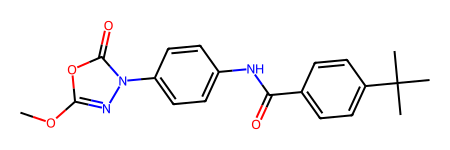

In [6]:
print(f"SMILES:\t{df.canonical_smiles[100]}\nlogP:\t{df.LogP[100]}\nqed:\t{df.qed[100]}")
molecule = molecule_from_smiles(df.iloc[29].canonical_smiles)
print("Molecule:")
molecule

# Get unique types of atoms 

In [7]:
from rdkit import Chem

# Get the unique atomic symbols present in the SMILES strings
unique_atoms = set()
for smile in df['canonical_smiles']:
    mol = Chem.MolFromSmiles(smile)
    atoms = mol.GetAtoms()
    for atom in atoms:
        symbol = atom.GetSymbol()
        unique_atoms.add(symbol)

# Print the unique atomic symbols
print("Unique atoms:", unique_atoms)


Unique atoms: {'I', 'C', 'P', 'S', 'O', 'Cl', 'Se', 'N', 'F', 'Br', 'Si'}


In [8]:
SMILE_CHARSET= '["Cl", "Se", "P", "O", "Si", "I", "N", "S", "C", "Br", "F", "H"]'  
bond_mapping = {
    "SINGLE": 0,
    0: Chem.BondType.SINGLE,
    "DOUBLE": 1,
    1: Chem.BondType.DOUBLE,
    "TRIPLE": 2,
    2: Chem.BondType.TRIPLE,
    "AROMATIC": 3,
    3: Chem.BondType.AROMATIC,
}
SMILE_CHARSET = ast.literal_eval(SMILE_CHARSET)

MAX_MOLSIZE = max(df['canonical_smiles'].str.len())
SMILE_to_index = dict((c, i) for i, c in enumerate(SMILE_CHARSET))
index_to_SMILE = dict((i, c) for i, c in enumerate(SMILE_CHARSET))
atom_mapping = dict(SMILE_to_index)
atom_mapping.update(index_to_SMILE)

print("Max molecule size: {}".format(MAX_MOLSIZE))
print("Character set Length: {}".format(len(SMILE_CHARSET)))

Max molecule size: 192
Character set Length: 12


## Hyperparameters

In [9]:
BATCH_SIZE = 20
EPOCHS =6
VAE_LR = 5e-4
NUM_ATOMS = 192 # Maximum number of atoms

ATOM_DIM = 12  # Number of atom types
BOND_DIM = 3 + 1  # Number of bond types
LATENT_DIM = 335  # Size of the latent space

In [10]:
def smiles_to_graph(smiles):
    '''
    Reference: https://keras.io/examples/generative/wgan-graphs/
    '''
    # Converts SMILES to molecule object
    molecule = Chem.MolFromSmiles(smiles)

    # Initialize adjacency and feature tensor
    adjacency = np.zeros((BOND_DIM, NUM_ATOMS, NUM_ATOMS), "float32")
    features = np.zeros((NUM_ATOMS, ATOM_DIM), "float32")

    # loop over each atom in molecule
    for atom in molecule.GetAtoms():
        i = atom.GetIdx()
        atom_type = atom_mapping[atom.GetSymbol()]
        features[i] = np.eye(ATOM_DIM)[atom_type]
        # loop over one-hop neighbors
        for neighbor in atom.GetNeighbors():
            j = neighbor.GetIdx()
            bond = molecule.GetBondBetweenAtoms(i, j)
            bond_type_idx = bond_mapping[bond.GetBondType().name]
            adjacency[bond_type_idx, [i, j], [j, i]] = 1

    # Where no bond, add 1 to last channel (indicating "non-bond")
    # Notice: channels-first
    adjacency[-1, np.sum(adjacency, axis=0) == 0] = 1

    # Where no atom, add 1 to last column (indicating "non-atom")
    features[np.where(np.sum(features, axis=1) == 0)[0], -1] = 1

    return adjacency, features

def graph_to_molecule(graph):
    '''
    Reference: https://keras.io/examples/generative/wgan-graphs/
    '''
    # Unpack graph
    adjacency, features = graph

    # RWMol is a molecule object intended to be edited
    molecule = Chem.RWMol()

    # Remove "no atoms" & atoms with no bonds
    keep_idx = np.where(
        (np.argmax(features, axis=1) != ATOM_DIM - 1)
        & (np.sum(adjacency[:-1], axis=(0, 1)) != 0)
    )[0]
    features = features[keep_idx]
    adjacency = adjacency[:, keep_idx, :][:, :, keep_idx]

    # Add atoms to molecule
    for atom_type_idx in np.argmax(features, axis=1):
        atom = Chem.Atom(atom_mapping[atom_type_idx])
        _ = molecule.AddAtom(atom)

    # Add bonds between atoms in molecule; based on the upper triangles
    # of the [symmetric] adjacency tensor
    (bonds_ij, atoms_i, atoms_j) = np.where(np.triu(adjacency) == 1)
    for (bond_ij, atom_i, atom_j) in zip(bonds_ij, atoms_i, atoms_j):
        if atom_i == atom_j or bond_ij == BOND_DIM - 1:
            continue
        bond_type = bond_mapping[bond_ij]
        molecule.AddBond(int(atom_i), int(atom_j), bond_type)

    # Sanitize the molecule; for more information on sanitization, see
    # https://www.rdkit.org/docs/RDKit_Book.html#molecular-sanitization
    flag = Chem.SanitizeMol(molecule, catchErrors=True)
    # Let's be strict. If sanitization fails, return None
    if flag != Chem.SanitizeFlags.SANITIZE_NONE:
        return None

    return molecule

## Build Dataloader

The VAEDataLoader class above takes in the data and batch size as input, and returns a DataLoader object that can be used for training and validation of the VAE model.

A DataLoader is an important component in training machine learning models that require large datasets. It helps to load the data in a more efficient and manageable way. In the context of a Variational Autoencoder (VAE) model, a DataLoader is used to load the training and validation data for the model.

In [11]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, data, mapping, max_len, batch_size=2, shuffle=True):
        """
        Initialization
        """
        self.data = data
        self.indices = self.data.index.tolist()
        self.mapping = mapping
        self.max_len = max_len
        self.batch_size = batch_size
        self.shuffle = shuffle
        
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.data) / self.batch_size))

    def __getitem__(self, index):
        if (index + 1) * self.batch_size > len(self.indices):
            self.batch_size = len(self.indices) - index * self.batch_size
        # Generate one batch of data
        # Generate indices of the batch
        index = self.indices[index * self.batch_size : (index + 1) * self.batch_size]
        # Find list of IDs
        batch = [self.indices[k] for k in index]
        mol_features, mol_property = self.data_generation(batch)

        return mol_features, mol_property

    def on_epoch_end(self):

        """
        Updates indexes after each epoch
        """
        self.index = np.arange(len(self.indices))
#         if self.shuffle == True:
#             np.random.shuffle(self.index)

    def load(self, idx):
        """
        Load molecules adjacency matrix and features matrix from SMILE representation 
        and their respective SAS value.
        """
        qed = self.data.loc[idx]['qed']

        adjacency, features = smiles_to_graph(self.data.loc[idx]['canonical_smiles'])

        return adjacency, features, qed

        
    def data_generation(self, batch):

        x1 = np.empty((self.batch_size, BOND_DIM, self.max_len, self.max_len))
        x2 = np.empty((self.batch_size, self.max_len, len(self.mapping)))
        x3 = np.empty((self.batch_size, ))
        
        for i, batch_id in enumerate(batch):
            x1[i,], x2[i,], x3[i,] = self.load(batch_id)

        return [x1, x2], x3


The __init__() method initializes the data generator with the input data, a mapping of features to integers, and parameters such as the batch size and whether or not to shuffle the data after each epoch. 

The on_epoch_end() method is called after each epoch of training, and updates the indices for the next epoch.

The __len__() method returns the number of batches in the data generator.

The __getitem__() method generates one batch of data by selecting a subset of indices corresponding to the batch, and then generating the corresponding adjacency matrices, feature matrices, and target property values using the data_generation() method. 

The load() method takes an index and returns the corresponding adjacency matrix, feature matrix, and target property value, which are generated by calling the smiles_to_graph() function.

The data_generation() method generates a batch of data by looping over the indices in the batch and calling load() for each index, and then returning the resulting numpy arrays.

##  Generate training set

In [12]:
train_df = df.sample(frac=0.75,random_state=42) #random state is a seed value
test_df = df.drop(train_df.index)
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [13]:
train_df[:5595]

,molecule_chembl_id,num_atoms,num_rings,NumHeteroatoms,num_atoms.1,num_rings.1,NumValenceElectron,NumAliphaticCarbocycles,NumSaturatedRings,NumRotatableBonds,Class,MW,LogP,NumHDonors,NumHAcceptors,Mol2D,canonical_smiles,pIC50,qed
0,CHEMBL3972317,32,4,10,32,4,168,1,0,4,active,444.438,4.09050,2.0,7.0,<rdkit.Chem.rdchem.Mol object at 0x0000022A3DF...,CCOC(=O)C1=C(C)Nc2nc3c(c(N)c2C1c1cccc([N+](=O)...,6.297569,0.413899
1,CHEMBL4762419,41,5,8,41,5,220,1,0,12,active,580.169,7.13380,3.0,6.0,<rdkit.Chem.rdchem.Mol object at 0x0000022A3DF...,COc1cc2c(cc1O)CCC(C)(CCC(=O)NCCCCCCNc1c3c(nc4c...,8.420216,0.197587
2,CHEMBL3828679,31,2,7,31,2,178,0,0,10,active,501.506,2.03362,0.0,4.0,<rdkit.Chem.rdchem.Mol object at 0x0000022A3DF...,CCCCCCCCCC(C)C1OCc2c[n+](C)c(C)c(OC(=O)N(C)C)c...,6.337242,0.392707
3,CHEMBL3415579,26,3,5,26,3,136,0,0,9,intermediate,370.880,4.28620,1.0,3.0,<rdkit.Chem.rdchem.Mol object at 0x0000022A5B8...,O=C1c2ccccc2C(=O)N1CCCCCCNCc1cccc(Cl)c1,5.697236,0.528918
4,CHEMBL158252,21,3,4,21,3,112,0,1,3,active,286.375,2.55960,1.0,3.0,<rdkit.Chem.rdchem.Mol object at 0x0000022A3DE...,CN1CCC(CCC2C(=O)Nc3ccccc3C2=O)CC1,8.376751,0.868810
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4192,CHEMBL603256,39,5,4,39,5,204,1,1,12,active,522.733,7.17600,0.0,4.0,<rdkit.Chem.rdchem.Mol object at 0x0000022A5B8...,CN(Cc1ccccc1)Cc1ccc(/C=C2\Cc3ccc(OCCCCCN4CCCCC...,6.698970,0.186375
4193,CHEMBL4075825,20,4,4,20,4,98,0,0,1,inactive,262.316,2.99710,0.0,4.0,<rdkit.Chem.rdchem.Mol object at 0x0000022A3DF...,CN1c2ccccc2C(n2cncn2)c2ccccc21,4.725842,0.675763
4194,CHEMBL416,16,3,4,16,3,80,0,0,1,inactive,216.192,2.54780,0.0,4.0,<rdkit.Chem.rdchem.Mol object at 0x0000022A3DE...,COc1c2occc2cc2ccc(=O)oc12,4.267606,0.586359
4195,CHEMBL3919086,29,3,4,29,3,148,0,0,8,intermediate,386.495,4.97910,1.0,3.0,<rdkit.Chem.rdchem.Mol object at 0x0000022A3DF...,COc1cccc(/C=C/C(=O)Nc2ccc(CN(C)Cc3ccccc3)cc2)c1,5.330683,0.555340


In [14]:
train_df

,molecule_chembl_id,num_atoms,num_rings,NumHeteroatoms,num_atoms.1,num_rings.1,NumValenceElectron,NumAliphaticCarbocycles,NumSaturatedRings,NumRotatableBonds,Class,MW,LogP,NumHDonors,NumHAcceptors,Mol2D,canonical_smiles,pIC50,qed
0,CHEMBL3972317,32,4,10,32,4,168,1,0,4,active,444.438,4.09050,2.0,7.0,<rdkit.Chem.rdchem.Mol object at 0x0000022A3DF...,CCOC(=O)C1=C(C)Nc2nc3c(c(N)c2C1c1cccc([N+](=O)...,6.297569,0.413899
1,CHEMBL4762419,41,5,8,41,5,220,1,0,12,active,580.169,7.13380,3.0,6.0,<rdkit.Chem.rdchem.Mol object at 0x0000022A3DF...,COc1cc2c(cc1O)CCC(C)(CCC(=O)NCCCCCCNc1c3c(nc4c...,8.420216,0.197587
2,CHEMBL3828679,31,2,7,31,2,178,0,0,10,active,501.506,2.03362,0.0,4.0,<rdkit.Chem.rdchem.Mol object at 0x0000022A3DF...,CCCCCCCCCC(C)C1OCc2c[n+](C)c(C)c(OC(=O)N(C)C)c...,6.337242,0.392707
3,CHEMBL3415579,26,3,5,26,3,136,0,0,9,intermediate,370.880,4.28620,1.0,3.0,<rdkit.Chem.rdchem.Mol object at 0x0000022A5B8...,O=C1c2ccccc2C(=O)N1CCCCCCNCc1cccc(Cl)c1,5.697236,0.528918
4,CHEMBL158252,21,3,4,21,3,112,0,1,3,active,286.375,2.55960,1.0,3.0,<rdkit.Chem.rdchem.Mol object at 0x0000022A3DE...,CN1CCC(CCC2C(=O)Nc3ccccc3C2=O)CC1,8.376751,0.868810
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4192,CHEMBL603256,39,5,4,39,5,204,1,1,12,active,522.733,7.17600,0.0,4.0,<rdkit.Chem.rdchem.Mol object at 0x0000022A5B8...,CN(Cc1ccccc1)Cc1ccc(/C=C2\Cc3ccc(OCCCCCN4CCCCC...,6.698970,0.186375
4193,CHEMBL4075825,20,4,4,20,4,98,0,0,1,inactive,262.316,2.99710,0.0,4.0,<rdkit.Chem.rdchem.Mol object at 0x0000022A3DF...,CN1c2ccccc2C(n2cncn2)c2ccccc21,4.725842,0.675763
4194,CHEMBL416,16,3,4,16,3,80,0,0,1,inactive,216.192,2.54780,0.0,4.0,<rdkit.Chem.rdchem.Mol object at 0x0000022A3DE...,COc1c2occc2cc2ccc(=O)oc12,4.267606,0.586359
4195,CHEMBL3919086,29,3,4,29,3,148,0,0,8,intermediate,386.495,4.97910,1.0,3.0,<rdkit.Chem.rdchem.Mol object at 0x0000022A3DF...,COc1cccc(/C=C/C(=O)Nc2ccc(CN(C)Cc3ccccc3)cc2)c1,5.330683,0.555340


In [15]:
test_df[:5595]

,molecule_chembl_id,num_atoms,num_rings,NumHeteroatoms,num_atoms.1,num_rings.1,NumValenceElectron,NumAliphaticCarbocycles,NumSaturatedRings,NumRotatableBonds,Class,MW,LogP,NumHDonors,NumHAcceptors,Mol2D,canonical_smiles,pIC50,qed
0,CHEMBL131588,28,3,10,28,3,146,0,0,4,inactive,426.851,5.35740,0.0,5.0,<rdkit.Chem.rdchem.Mol object at 0x0000022A4FC...,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,4.301030,0.527034
1,CHEMBL130628,26,3,10,26,3,140,0,1,3,active,404.845,4.70690,0.0,5.0,<rdkit.Chem.rdchem.Mol object at 0x0000022A4FC...,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,6.522879,0.695219
2,CHEMBL130478,23,2,10,23,2,124,0,0,3,active,346.334,3.09530,0.0,6.0,<rdkit.Chem.rdchem.Mol object at 0x0000022A4FC...,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,6.096910,0.799502
3,CHEMBL130112,24,3,6,24,3,122,0,0,3,intermediate,338.436,4.07992,0.0,5.0,<rdkit.Chem.rdchem.Mol object at 0x0000022A3E3...,CSc1nc(-c2ccc(C)cc2)nn1C(=O)N(C)c1ccccc1,5.619789,0.675319
4,CHEMBL131051,28,3,10,28,3,146,0,0,4,inactive,408.405,4.67010,0.0,6.0,<rdkit.Chem.rdchem.Mol object at 0x0000022A3DE...,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)c1ccccc1,4.301030,0.587404
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1394,CHEMBL5080685,35,4,5,35,4,186,1,0,12,active,474.645,6.90400,1.0,5.0,<rdkit.Chem.rdchem.Mol object at 0x0000022A5E7...,COC(=O)c1c(CCCCCCCCNc2c3c(nc4ccccc24)CCCC3)ccc...,7.681937,0.228383
1395,CHEMBL5078555,36,4,6,36,4,192,1,0,12,active,509.090,7.55740,1.0,5.0,<rdkit.Chem.rdchem.Mol object at 0x0000022A5E7...,COC(=O)c1c(CCCCCCCCNc2c3c(nc4cc(Cl)ccc24)CCCC3...,8.595166,0.201883
1396,CHEMBL5091660,31,4,3,31,4,164,1,0,11,active,416.609,7.11740,1.0,3.0,<rdkit.Chem.rdchem.Mol object at 0x0000022A5E7...,COc1cccc(CCCCCCCCNc2c3c(nc4ccccc24)CCCC3)c1,7.397940,0.337966
1397,CHEMBL5088541,33,4,4,33,4,176,1,0,12,active,446.635,7.12600,1.0,4.0,<rdkit.Chem.rdchem.Mol object at 0x0000022A5E7...,COc1cc(CCCCCCCCNc2c3c(nc4ccccc24)CCCC3)cc(OC)c1,7.326058,0.300657


Relational Graph Convolutional Layer is a type of convolutional layer used in graph neural networks (GNNs) for semi-supervised learning tasks. It operates on graph-structured data, where each node in the graph represents an object or entity, and edges represent relationships or interactions between them. 
GCN is a specific type of GNN that performs graph convolution using spectral methods, while GNN is a broader category that includes different types of neural networks that operate on graph-structured data.

In [16]:
'''
    Reference: https://keras.io/examples/generative/wgan-graphs/
'''
class RelationalGraphConvLayer(keras.layers.Layer):
    def __init__(
        self,
        units=128,
        activation="relu",
        use_bias=False,
        kernel_initializer="glorot_uniform",
        bias_initializer="zeros",
        kernel_regularizer=None,
        bias_regularizer=None,
        **kwargs
    ):
        super().__init__(**kwargs)

        self.units = units
        self.activation = keras.activations.get(activation)
        self.use_bias = use_bias
        self.kernel_initializer = keras.initializers.get(kernel_initializer)
        self.bias_initializer = keras.initializers.get(bias_initializer)
        self.kernel_regularizer = keras.regularizers.get(kernel_regularizer)
        self.bias_regularizer = keras.regularizers.get(bias_regularizer)

#The build method of the RelationalGraphConvLayer class creates the layer weights when the layer is first used.
        
    def build(self, input_shape):
        bond_dim = input_shape[0][1]
        atom_dim = input_shape[1][2]

        self.kernel = self.add_weight(
            shape=(bond_dim, atom_dim, self.units),
            initializer=self.kernel_initializer,
            regularizer=self.kernel_regularizer,
            trainable=True,
            name="W",
            dtype=tf.float32,
        )

        if self.use_bias:
            self.bias = self.add_weight(
                shape=(bond_dim, 1, self.units),
                initializer=self.bias_initializer,
                regularizer=self.bias_regularizer,
                trainable=True,
                name="b",
                dtype=tf.float32,
            )

        self.built = True
        
#This is the call method of the RelationalGraphConvLayer class. It applies the relational graph convolution operation to the input features and adjacency matrix.

    def call(self, inputs, training=False):
        adjacency, features = inputs
        # Aggregate information from neighbors
        x = tf.matmul(adjacency, features[:, None, :, :])
        # Apply linear transformation
        x = tf.matmul(x, self.kernel)
        if self.use_bias:
            x += self.bias
        # Reduce bond types dim
        x_reduced = tf.reduce_sum(x, axis=1)
        # Apply non-linear transformation
        return self.activation(x_reduced)

## Build the Encoder and Decoder
These functions are used to define the encoder and decoder models for a Variational Autoencoder (VAE) architecture that can generate molecular graphs.


In [17]:
def get_encoder(gconv_units, latent_dim, adjacency_shape, feature_shape, dense_units,dropout_rate ):
    '''
    Reference: https://keras.io/examples/generative/wgan-graphs/
    '''
    adjacency = keras.layers.Input(shape=adjacency_shape)
    features = keras.layers.Input(shape=feature_shape)

    # Propagate through one or more graph convolutional layers
    features_transformed = features
    for units in gconv_units:
        features_transformed = RelationalGraphConvLayer(units)(
            [adjacency, features_transformed]
        )
    # Reduce 2-D representation of molecule to 1-D
    x = keras.layers.GlobalAveragePooling1D()(features_transformed)

    # Propagate through one or more densely connected layers
    for units in dense_units:
        x = layers.Dense(units, activation="relu")(x)
        x = layers.Dropout(dropout_rate)(x)
    
    z_mean = layers.Dense(latent_dim, dtype="float32", name="z_mean")(x)
    log_var = layers.Dense(latent_dim, dtype="float32", name="log_var")(x)
    
    encoder = keras.Model([adjacency, features], [z_mean, log_var], name="encoder")

    return encoder

def get_decoder(dense_units, dropout_rate, latent_dim, adjacency_shape, feature_shape):
    '''
    Reference: https://keras.io/examples/generative/wgan-graphs/
    '''
    latent_inputs = keras.Input(shape=(latent_dim,))

    x = latent_inputs
    for units in dense_units:
        x = keras.layers.Dense(units, activation="tanh")(x)
        x = keras.layers.Dropout(dropout_rate)(x)

    # Map outputs of previous layer (x) to [continuous] adjacency tensors (x_adjacency)
    x_adjacency = keras.layers.Dense(tf.math.reduce_prod(adjacency_shape))(x)
    x_adjacency = keras.layers.Reshape(adjacency_shape)(x_adjacency)
    # Symmetrify tensors in the last two dimensions
    x_adjacency = (x_adjacency + tf.transpose(x_adjacency, (0, 1, 3, 2))) / 2
    x_adjacency = keras.layers.Softmax(axis=1)(x_adjacency)

    # Map outputs of previous layer (x) to [continuous] feature tensors (x_features)
    x_features = keras.layers.Dense(tf.math.reduce_prod(feature_shape))(x)
    x_features = keras.layers.Reshape(feature_shape)(x_features)
    x_features = keras.layers.Softmax(axis=2)(x_features)


    decoder = keras.Model(latent_inputs, outputs=[x_adjacency, x_features], name="decoder")

    return decoder

Get_Encoder: It defines the encoder architecture that maps the input molecular graph to its latent space representation. The encoder takes in two inputs: adjacency and features. The adjacency matrix represents the connectivity between atoms in the molecular graph, while the features matrix represents the different attributes of the atoms.

Get_Decoder : This function takes in various parameters such as dense_units, dropout_rate, latent_dim, adjacency_shape, and feature_shape. It defines the decoder architecture that maps the latent space representation back to a molecular graph. The decoder takes in one input: latent_inputs, which is the output of the encoder

## Build Sampling layer

In [18]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_log_var)[0]
        dim = tf.shape(z_log_var)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


This is a custom Keras layer called Sampling, which is used to sample from the latent space distribution of a Variational Autoencoder (VAE). The layer takes in the mean (z_mean) and log variance (z_log_var) of the latent space distribution as inputs, and generates a random sample z

# BUILD THE VAE

This code defines a class MoleculeGenerator in Keras, which inherits from the keras.Model class. This class is used to generate new molecules using a generative model.

In [19]:
class MoleculeGenerator(keras.Model):
    def __init__(self, encoder, decoder, max_len, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.property_prediction_layer = layers.Dense(1)
        self.max_len = max_len

        self.train_total_loss_tracker = keras.metrics.Mean(name="train_total_loss")
        self.val_total_loss_tracker = keras.metrics.Mean(name="val_total_loss")
    
    def train_step(self, data):
        mol_features, mol_property = data
        graph_real = mol_features
        self.batch_size = tf.shape(mol_property)[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, property_prediction, \
             reconstruction_adjacency, reconstruction_features = self(mol_features,
                                                                             training=True)
            graph_generated = [reconstruction_adjacency, reconstruction_features]
            total_loss = self.calculate_loss(z_log_var,
                                             z_mean,
                                             mol_property,
                                             property_prediction,
                                             graph_real,
                                             graph_generated,
                                             is_train=True)

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.train_total_loss_tracker.update_state(total_loss)
        return {
            "loss": self.train_total_loss_tracker.result(),
        }

    def test_step(self, data):
        mol_features, mol_property = data
        z_mean, z_log_var, property_prediction, \
        reconstruction_adjacency, reconstruction_features = self(mol_features,
                                                                training=False)
        total_loss = self.calculate_loss(z_log_var,
                                        z_mean,
                                        mol_property, 
                                        property_prediction,
                                        graph_real=mol_features,
                                        graph_generated=[reconstruction_adjacency, 
                                                         reconstruction_features],
                                        is_train=False)

        self.val_total_loss_tracker.update_state(total_loss)
        return {
            "loss": self.val_total_loss_tracker.result()
        }

    def calculate_loss(self,
                       z_log_var,
                       z_mean,
                       mol_property,
                       property_prediction,
                       graph_real,
                       graph_generated,
                       is_train):
        adjacency_real, features_real = graph_real
        adjacency_generated, features_generated = graph_generated
        
        adjacency_reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.categorical_crossentropy(
                                                        adjacency_real,
                                                        adjacency_generated
                                                        ),
                                                        axis=(1,2)
                    )
            )
        features_reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.categorical_crossentropy(
                                                        features_real,
                                                        features_generated
                                                        ),
                                                        axis=(1)
                    )
            )
        kl_loss = -0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), 1)
        kl_loss = tf.reduce_mean(kl_loss)

        property_prediction_loss = tf.reduce_mean(
            keras.losses.binary_crossentropy(mol_property, 
                                                property_prediction)
        )

        if is_train:
            graph_loss = self._gradient_penalty(graph_real, graph_generated)
        else:
            graph_loss = 0

        return kl_loss + property_prediction_loss + graph_loss + adjacency_reconstruction_loss + features_reconstruction_loss

    def _gradient_penalty(self, graph_real, graph_generated):
        # Unpack graphs
        adjacency_real, features_real = graph_real
        adjacency_generated, features_generated = graph_generated

        # Generate interpolated graphs (adjacency_interp and features_interp)
        alpha = tf.random.uniform([self.batch_size])
        alpha = tf.reshape(alpha, (self.batch_size, 1, 1, 1))
        adjacency_interp = (adjacency_real * alpha) + (1 - alpha) * adjacency_generated
        alpha = tf.reshape(alpha, (self.batch_size, 1, 1))
        features_interp = (features_real * alpha) + (1 - alpha) * features_generated

        # Compute the logits of interpolated graphs
        with tf.GradientTape() as tape:
            tape.watch(adjacency_interp)
            tape.watch(features_interp)
            _, _, logits, _,_ = self(
                [adjacency_interp, features_interp], training=True
            )

        # Compute the gradients with respect to the interpolated graphs
        grads = tape.gradient(logits, [adjacency_interp, features_interp])
        # Compute the gradient penalty
        grads_adjacency_penalty = (1 - tf.norm(grads[0], axis=1)) ** 2
        grads_features_penalty = (1 - tf.norm(grads[1], axis=2)) ** 2
        return tf.reduce_mean(
            tf.reduce_mean(grads_adjacency_penalty, axis=(-2, -1))
            + tf.reduce_mean(grads_features_penalty, axis=(-1))
        )
   
    def inference(self, batch_size):
        z = tf.random.normal((batch_size, LATENT_DIM))
        reconstruction_adjacency, reconstruction_features = model.decoder.predict(z)
        # obtain one-hot encoded adjacency tensor
        adjacency = tf.argmax(reconstruction_adjacency, axis=1)
        adjacency = tf.one_hot(adjacency, depth=BOND_DIM, axis=1)
        # Remove potential self-loops from adjacency
        adjacency = tf.linalg.set_diag(adjacency, tf.zeros(tf.shape(adjacency)[:-1]))
        # obtain one-hot encoded feature tensor
        features = tf.argmax(reconstruction_features, axis=2)
        features = tf.one_hot(features, depth=ATOM_DIM, axis=2)
        return [
            graph_to_molecule([adjacency[i].numpy(), features[i].numpy()])
            for i in range(batch_size)
        ]
    def call(self, inputs):
        z_mean, log_var = self.encoder(inputs)
        z = Sampling()([z_mean, log_var])

        reconstruction_adjacency, reconstruction_features = self.decoder(z)

        property_prediction = self.property_prediction_layer(z_mean)

        return z_mean, log_var, property_prediction, reconstruction_adjacency, reconstruction_features
    def get_config(self):
        config = super().get_config().copy()
        # Add any custom hyperparameters here
        return config
   

In [20]:
def inference(self, batch_size):
            z = tf.random.normal((batch_size, LATENT_DIM))
            reconstruction_adjacency, reconstruction_features = self.decoder.predict(z)
            # obtain one-hot encoded adjacency tensor
            adjacency = tf.argmax(reconstruction_adjacency, axis=1)
            adjacency = tf.one_hot(adjacency, depth=BOND_DIM, axis=1)
            # Remove potential self-loops from adjacency
            adjacency = tf.linalg.set_diag(adjacency, tf.zeros(tf.shape(adjacency)[:-1]))
            # obtain one-hot encoded feature tensor
            features = tf.argmax(reconstruction_features, axis=2)
            features = tf.one_hot(features, depth=ATOM_DIM, axis=2)
            return [
                graph_to_molecule([adjacency[i].numpy(), features[i].numpy()])
                for i in range(batch_size)
            ]

The __init__ method initializes the class with an encoder and decoder model, a maximum length of the input sequence, and some trackers for training and validation losses.

 The train_step and test_step methods define the training and validation steps of the model, respectively.

The calculate_loss method calculates the loss function of the model, which is the sum of the KL divergence loss, property prediction loss, graph loss, adjacency reconstruction loss, and features reconstruction loss. 

The _gradient_penalty method computes the gradient penalty of the model, which is used as part of the graph loss.

The inference method generates new molecules using the decoder model.

## Train the model

In [21]:
train_loader = DataGenerator(
    data=train_df[:5595],
    mapping = SMILE_to_index, 
    max_len = NUM_ATOMS,
    batch_size=BATCH_SIZE
)

validation_loader = DataGenerator(
    data=test_df[:5595],
    mapping = SMILE_to_index, 
    max_len = NUM_ATOMS,
    batch_size=BATCH_SIZE
    )

In [22]:
vae_optimizer = tf.keras.optimizers.Adam(
    learning_rate=VAE_LR
)

encoder = get_encoder(
    gconv_units=[9],
    adjacency_shape=(BOND_DIM, NUM_ATOMS, NUM_ATOMS),
    feature_shape=(NUM_ATOMS, ATOM_DIM),
    latent_dim=LATENT_DIM,
    dense_units=[512],
    dropout_rate=0.0,
)
decoder = get_decoder(
    dense_units=[128, 256, 512],
    dropout_rate=0.2,
    latent_dim=LATENT_DIM,
    adjacency_shape=(BOND_DIM, NUM_ATOMS, NUM_ATOMS),
    feature_shape=(NUM_ATOMS, ATOM_DIM)
)




In [23]:
model = MoleculeGenerator(encoder, 
                          decoder,
                          MAX_MOLSIZE)
model.compile(vae_optimizer)

In [24]:
history = model.fit(train_loader,
                    epochs=EPOCHS,
                    validation_data=validation_loader)

Epoch 1/6
210/210 [==============================] - 248s 1s/step - loss: 194538.6573 - val_loss: 193768.1875
Epoch 2/6
210/210 [==============================] - 278s 1s/step - loss: 193897.4385 - val_loss: 194035.4844
Epoch 3/6
210/210 [==============================] - 289s 1s/step - loss: 194125.6946 - val_loss: 193742.7500
Epoch 4/6
210/210 [==============================] - 356s 2s/step - loss: 193740.7108 - val_loss: 193730.5938
Epoch 5/6
210/210 [==============================] - 419s 2s/step - loss: 193767.1607 - val_loss: 193800.0469          
Epoch 6/6
210/210 [==============================] - 1215s 6s/step - loss: 193904.9645 - val_loss: 193896.6719                                                                                                                                                


In [21]:
model.summary()

Model: "molecule_generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Functional)        [(None, 335),             349262    
                              (None, 335)]                       
                                                                 
 decoder (Functional)        [(None, 4, 192, 192),     77034496  
                              (None, 192, 12)]                   
                                                                 
 dense_6 (Dense)             multiple                  336       
                                                                 
Total params: 77,384,098
Trainable params: 77,384,094
Non-trainable params: 4
_________________________________________________________________


In [25]:
model.save('Vae_Alzheimer')

INFO:tensorflow:Assets written to: Vae_Alzheimer\assets


INFO:tensorflow:Assets written to: Vae_Alzheimer\assets


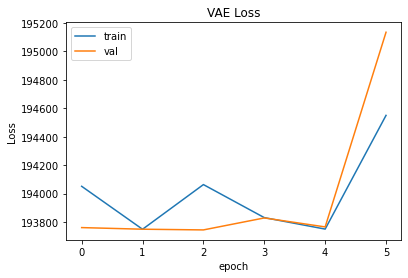

In [46]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('VAE Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Model Inferencing

We would be inferring our model to predict over random latent space and try to generate 100 new valid molecules.

### Generate unique Molecules with the model

In [26]:
loaded_model = tf.keras.models.load_model('Vae_Alzheimer')

In [34]:
molecules = inference(loaded_model, 2000)

63/63 [==============================] - 6s 97ms/step


In [35]:
molecules

 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [31]:
from rdkit.Chem import Descriptors
from rdkit.Chem import Draw
import PIL.Image


In [36]:
molecules_valides=[]
c=0

for mol in molecules:
    # Convertir la molécule en objet Mol
    if mol is None: 
        c=c+1
    else:
        mol1 = mol.GetMol()
        mw = Chem.Descriptors.MolWt(mol1)  # Poids moléculaire
        logp = Chem.Descriptors.MolLogP(mol1)  # LogP
        hba = Chem.Descriptors.NumHAcceptors(mol1)  # Nombre d'accepteurs de liaison hydrogène
        hbd = Chem.Descriptors.NumHDonors(mol1)  # Nombre de donneurs de liaison hydrogène

        # Afficher les résultats

        # Vérifier si la molécule satisfait les critères de la règle de Lipinski
        if mw <= 500 and logp <= 5 and hba <= 10 and hbd <= 5:
            molecules_valides.append(mol)
            # Convert list of RWMol objects to list of string representations
            molecules_smiles = [Chem.MolToSmiles(mol) for mol in molecules_valides]
                     # Convert list of string representations to set to remove duplicates
            unique_molecules_smiles_set = set(molecules_smiles)
            # Convert set back to list of string representations
            unique_molecules_smiles_list = list(unique_molecules_smiles_set)

            # Convert list of string representations back to list of RWMol objects
            unique_molecules = [Chem.MolFromSmiles(smiles) for smiles in unique_molecules_smiles_list]
            unique_smiles = [Chem.MolToSmiles(mol) for mol in unique_molecules] 


C:\Users\houss\anaconda3\lib\site-packages\rdkit\Chem\Draw\IPythonConsole.py:261: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn(


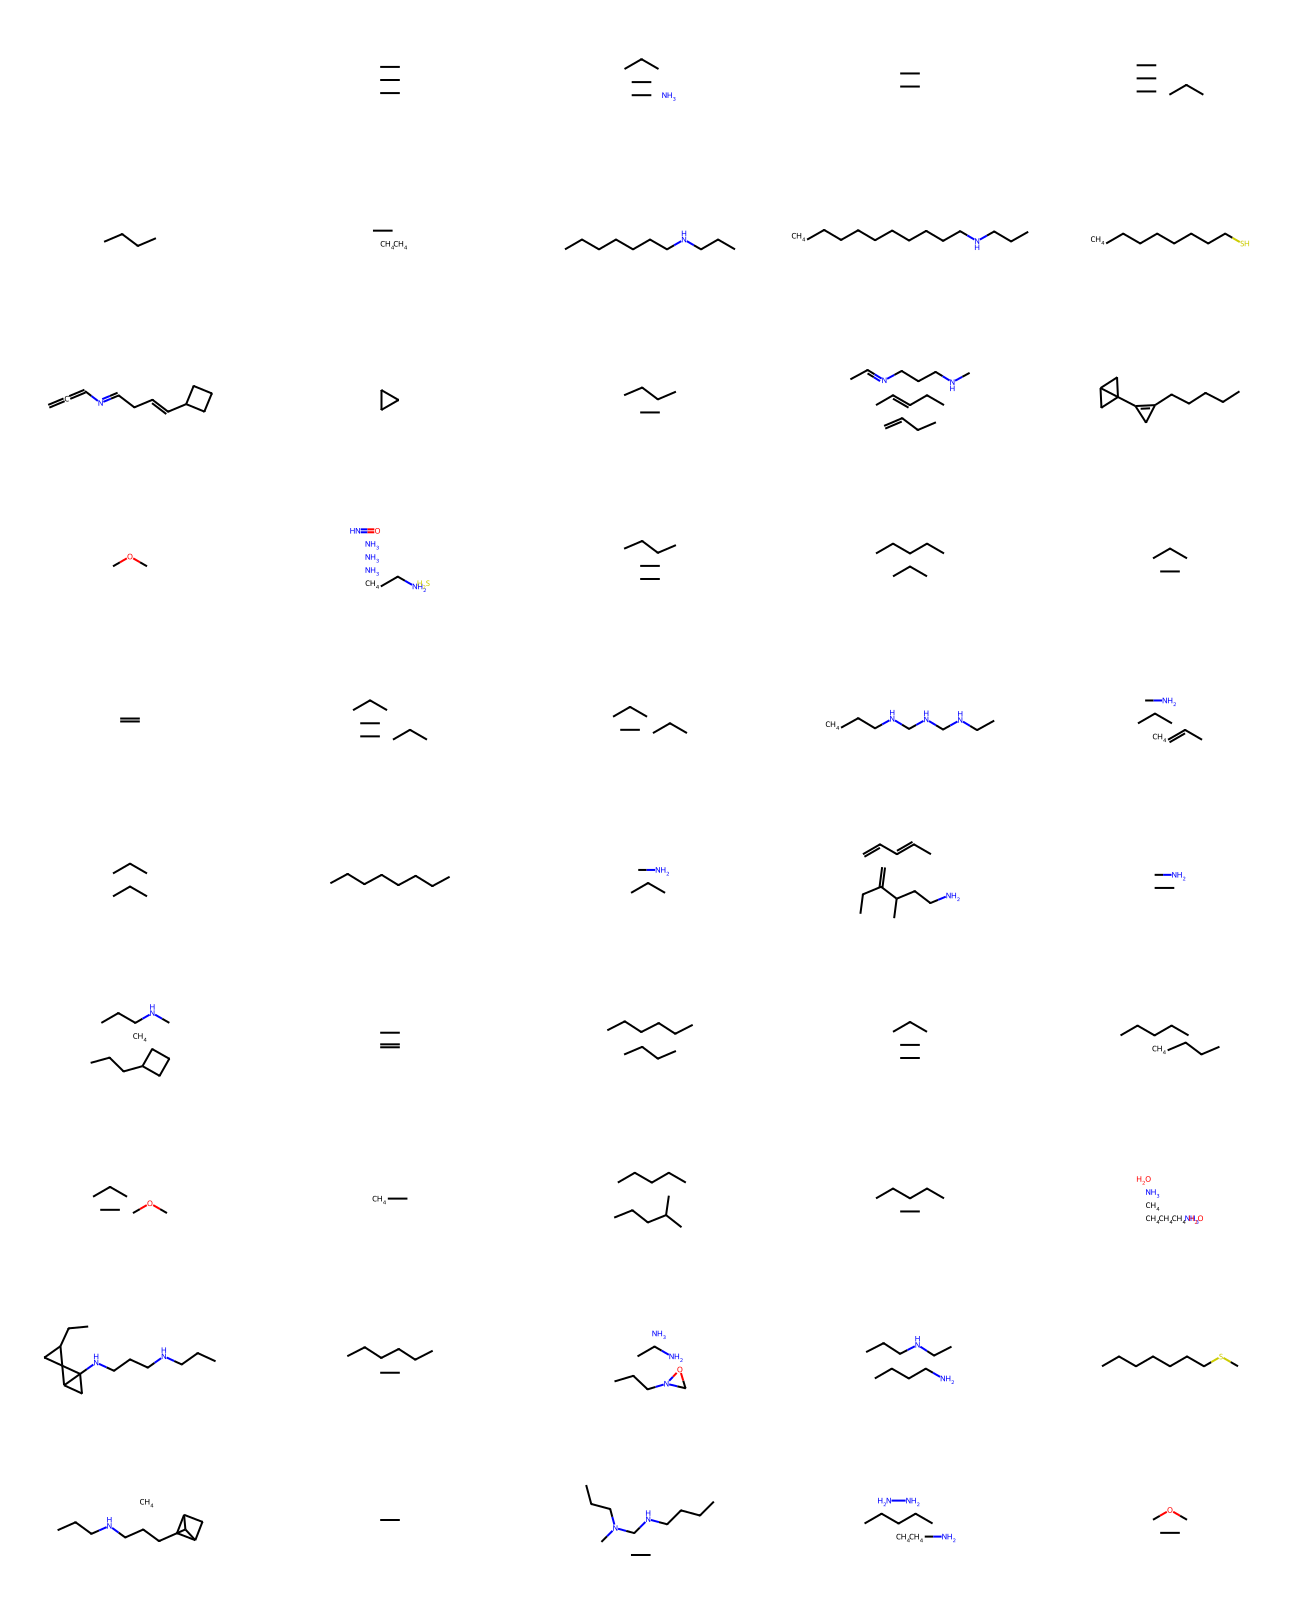

In [37]:
MolsToGridImage(
    [m for m in unique_molecules if m is not None][:2000], molsPerRow=5, subImgSize=(260, 160)
    )

# Validation of molecules 

validation with Lipinski

In [20]:
from molvs.validate import Validator
from rdkit.Chem import Descriptors
molecules_valides=[]
c=0
for mol in molecules:
    # Convertir la molécule en objet Mol
    if mol is None: 
        c=c+1
    else:
        mol1 = mol.GetMol()
        mw = Chem.Descriptors.MolWt(mol1)  # Poids moléculaire
        logp = Chem.Descriptors.MolLogP(mol1)  # LogP
        hba = Chem.Descriptors.NumHAcceptors(mol1)  # Nombre d'accepteurs de liaison hydrogène
        hbd = Chem.Descriptors.NumHDonors(mol1)  # Nombre de donneurs de liaison hydrogène

        # Afficher les résultats

        # Vérifier si la molécule satisfait les critères de la règle de Lipinski
        if mw <= 500 and logp <= 5 and hba <= 10 and hbd <= 5:
            molecules_valides.append(mol)
            # Convert list of RWMol objects to list of string representations
            molecules_smiles = [Chem.MolToSmiles(mol) for mol in molecules_valides]

            # Convert list of string representations to set to remove duplicates
            unique_molecules_smiles_set = set(molecules_smiles)
            # Convert set back to list of string representations
            unique_molecules_smiles_list = list(unique_molecules_smiles_set)

            # Convert list of string representations back to list of RWMol objects
            unique_molecules = [Chem.MolFromSmiles(smiles) for smiles in unique_molecules_smiles_list]
            unique_smiles = [Chem.MolToSmiles(mol) for mol in unique_molecules]
           



In [88]:
from rdkit.Chem.Draw import MolToImage
from rdkit.Chem.Draw import MolsToGridImage
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
images = [Draw.MolToImage(mol) for mol in unique_molecules]
for i, image in enumerate(images):
    image.save(f'mol_{i}.png')

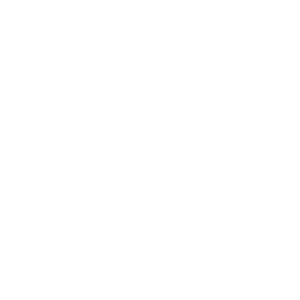

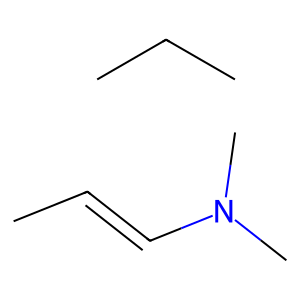

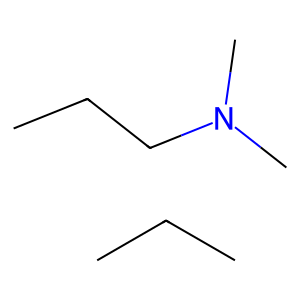

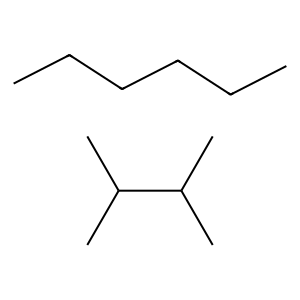

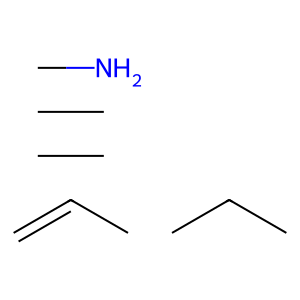

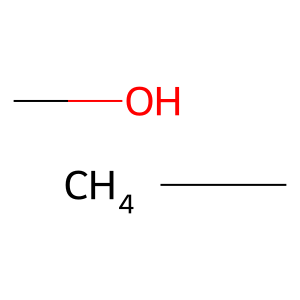

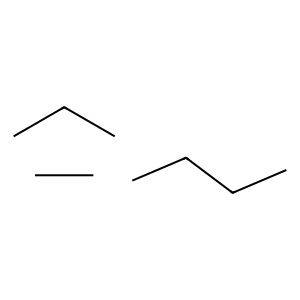

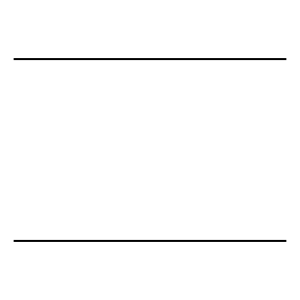

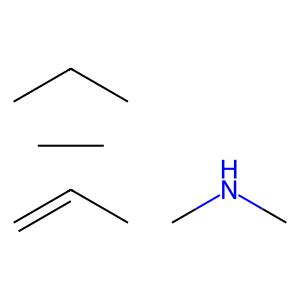

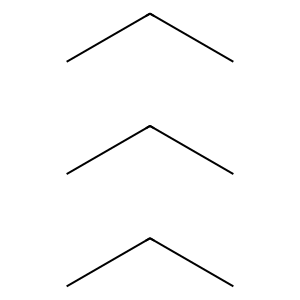

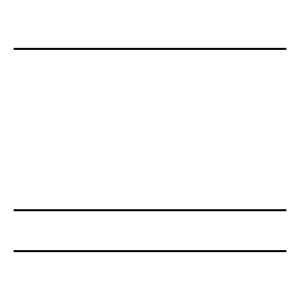

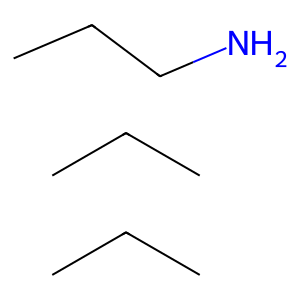

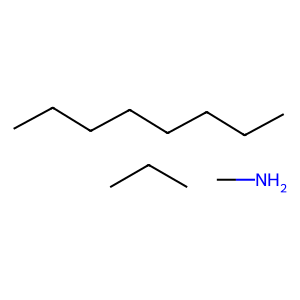

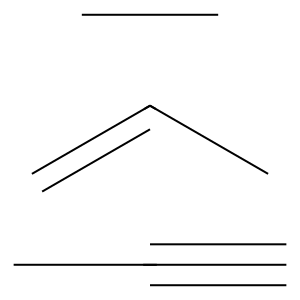

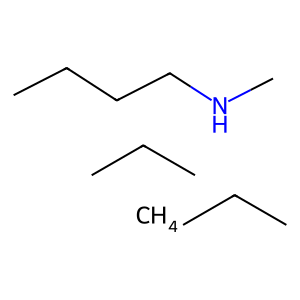

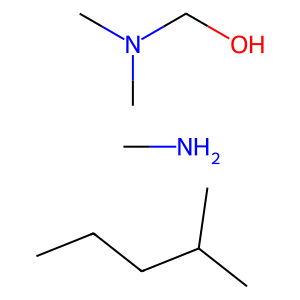

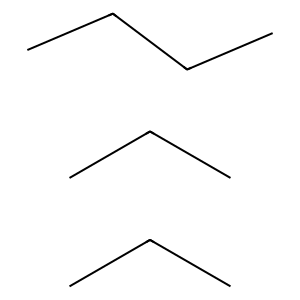

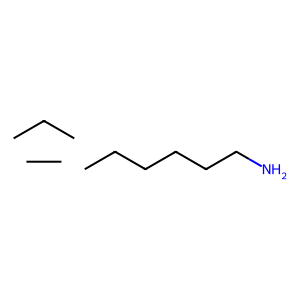

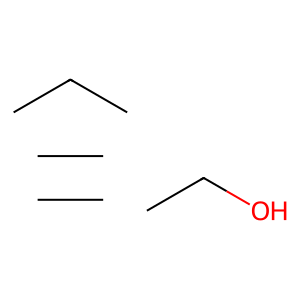

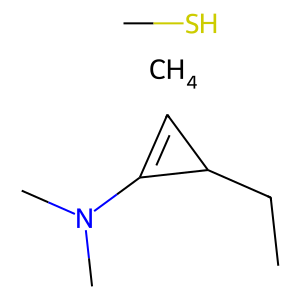

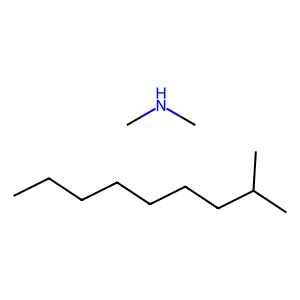

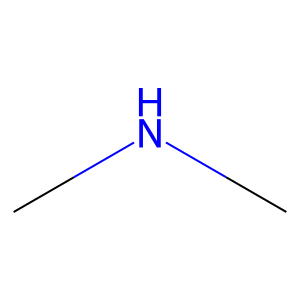

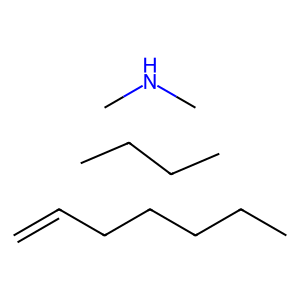

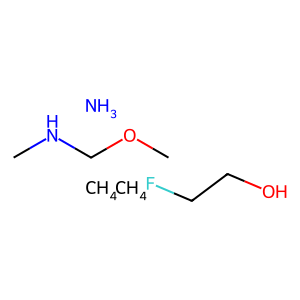

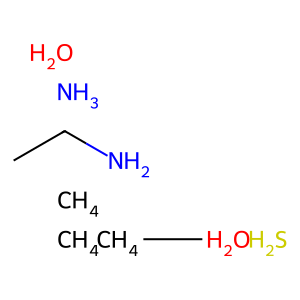

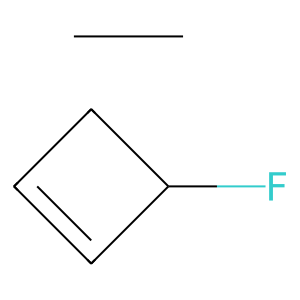

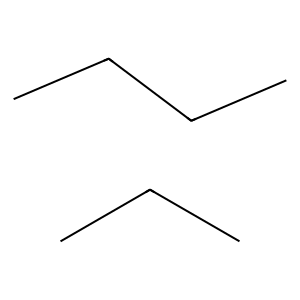

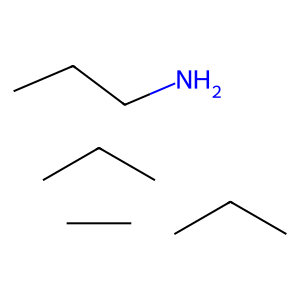

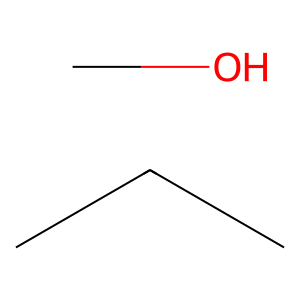

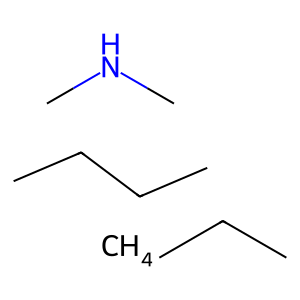

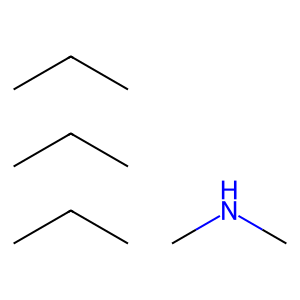

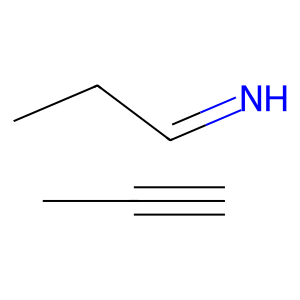

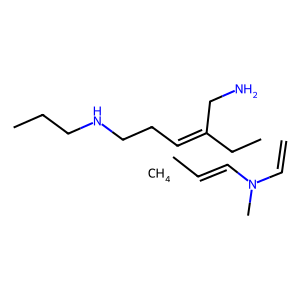

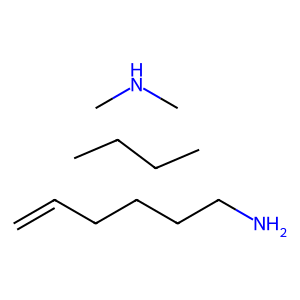

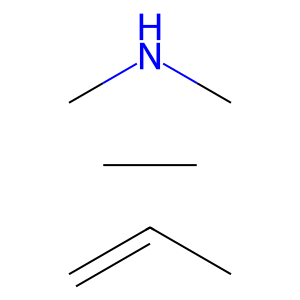

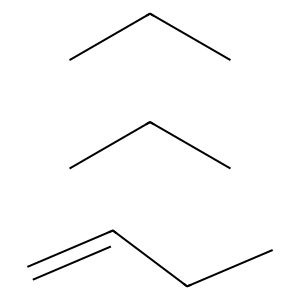

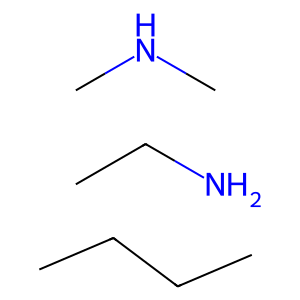

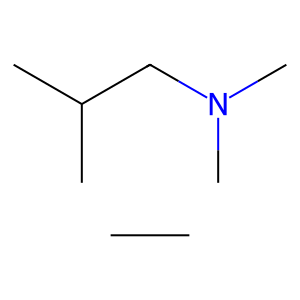

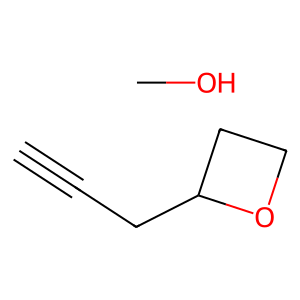

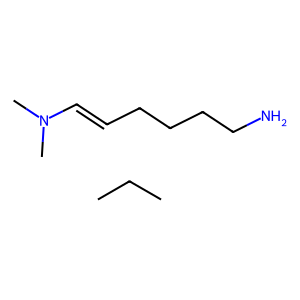

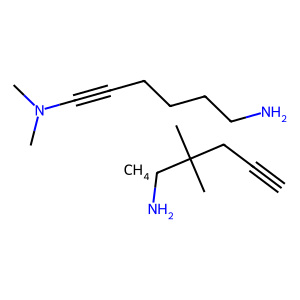

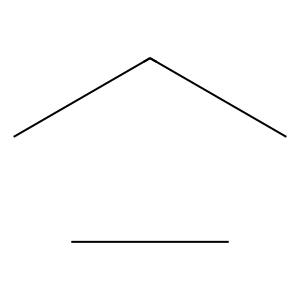

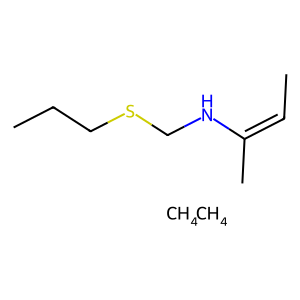

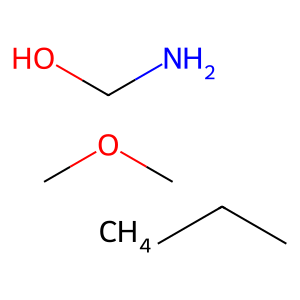

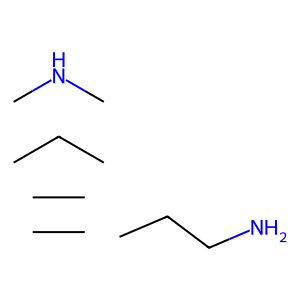

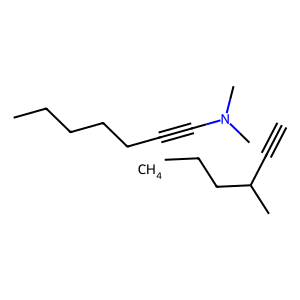

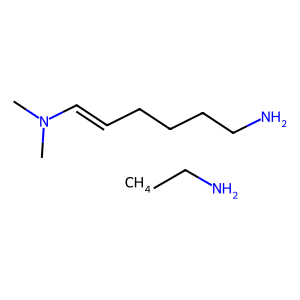

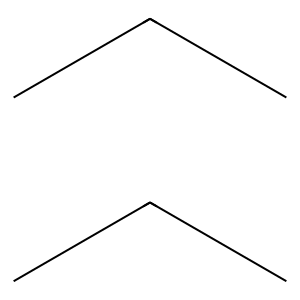

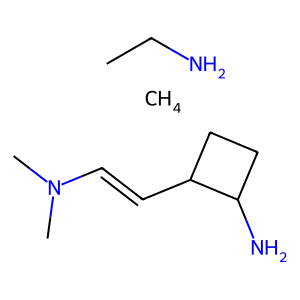

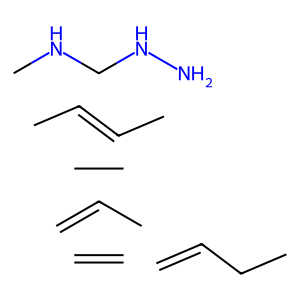

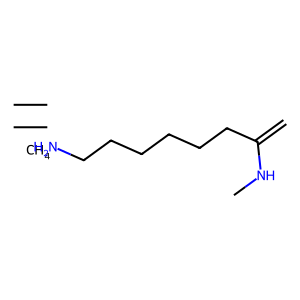

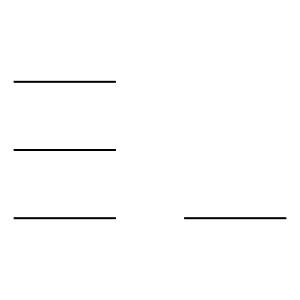

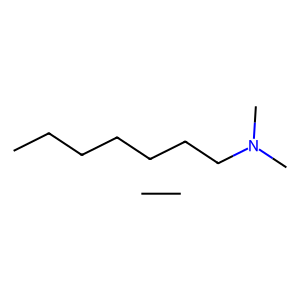

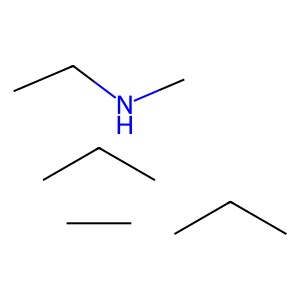

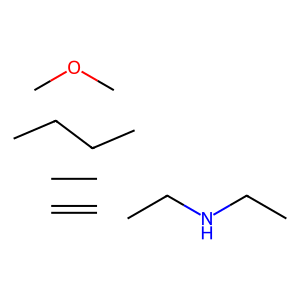

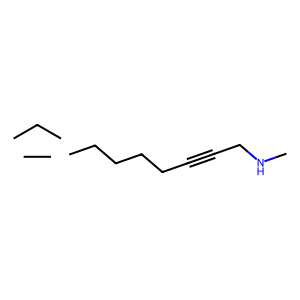

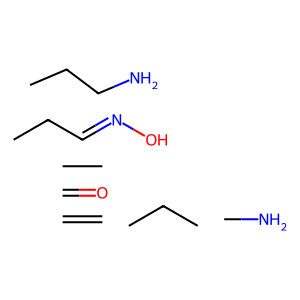

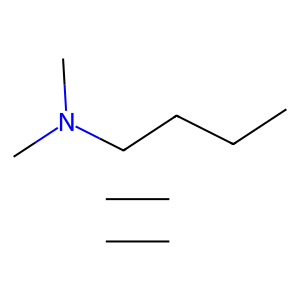

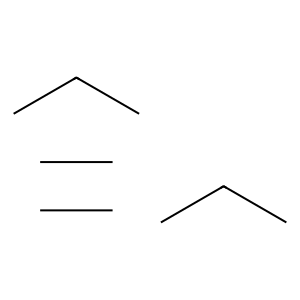

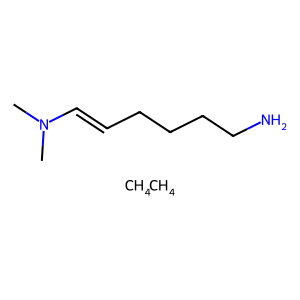

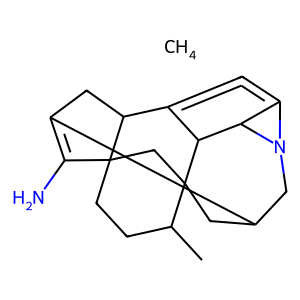

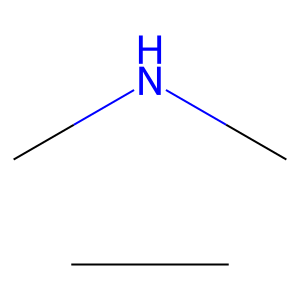

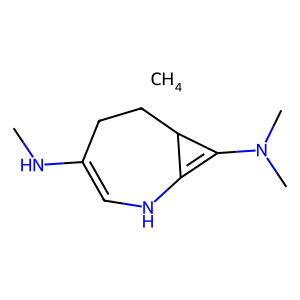

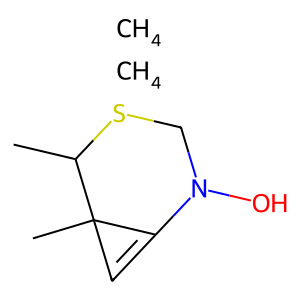

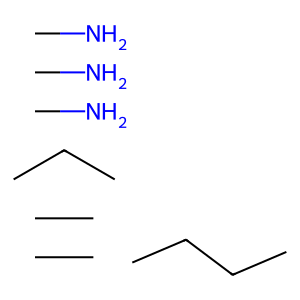

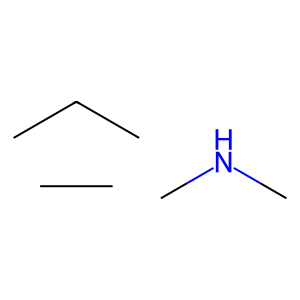

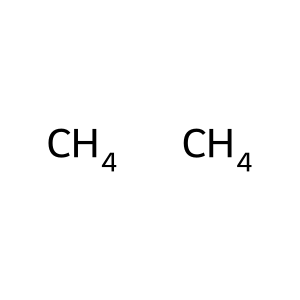

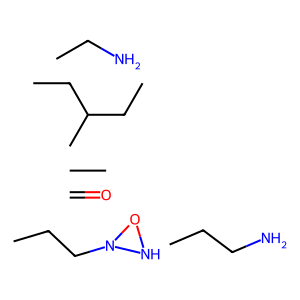

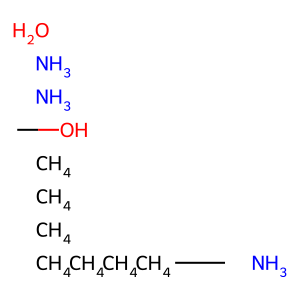

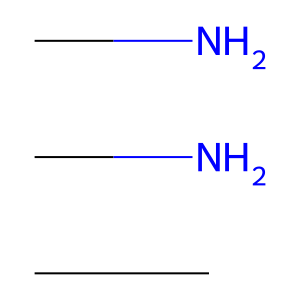

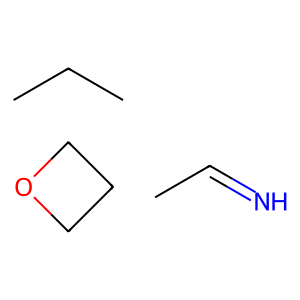

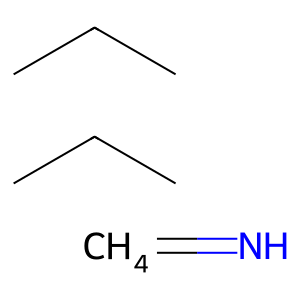

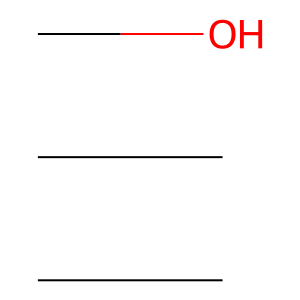

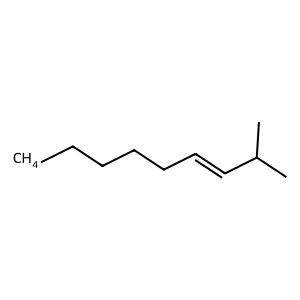

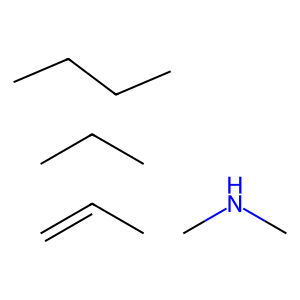

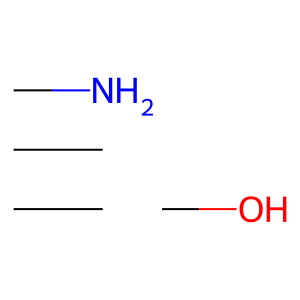

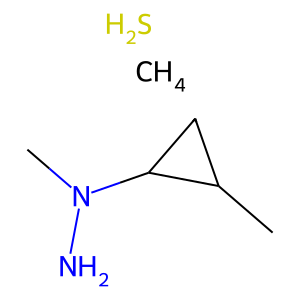

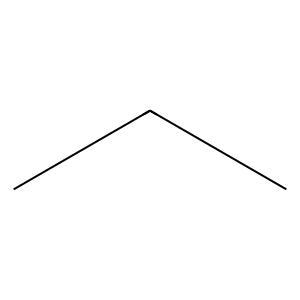

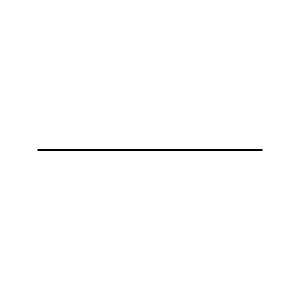

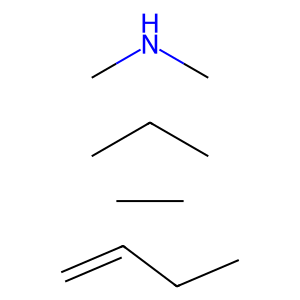

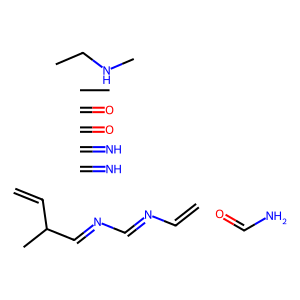

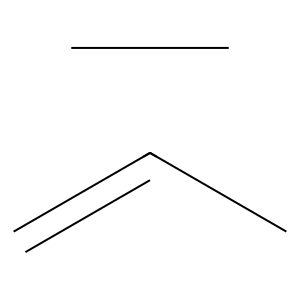

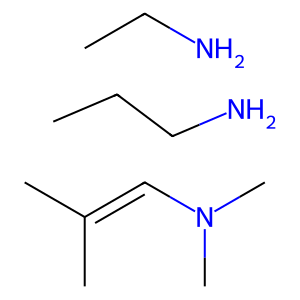

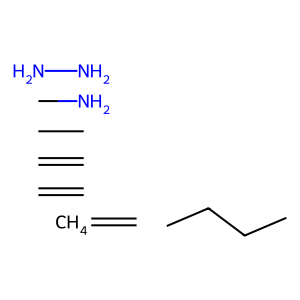

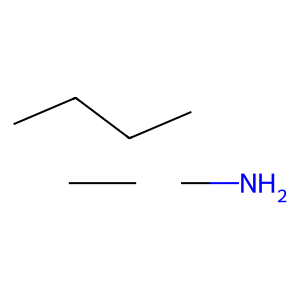

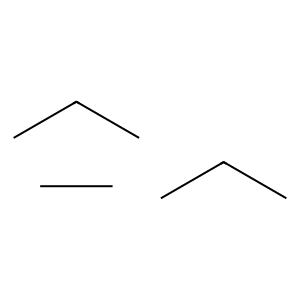

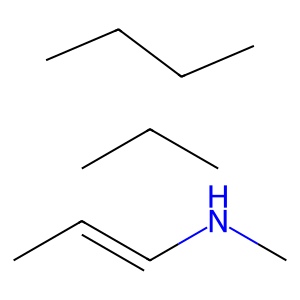

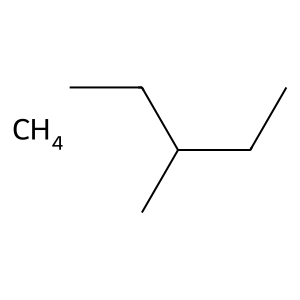

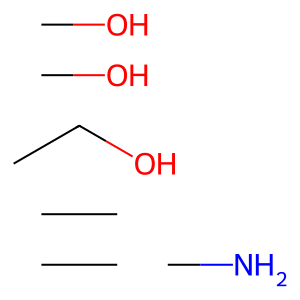

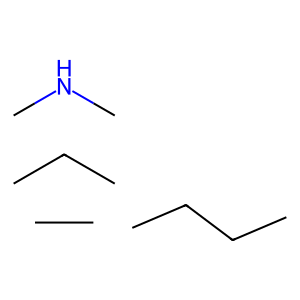

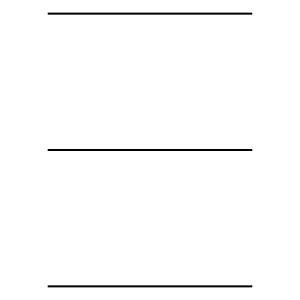

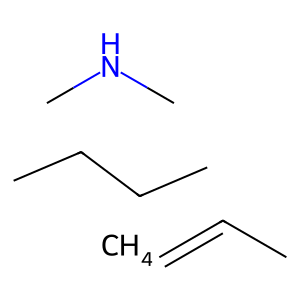

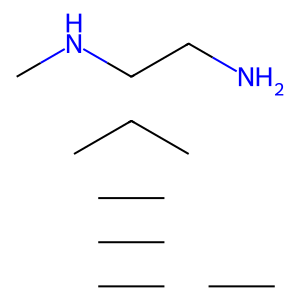

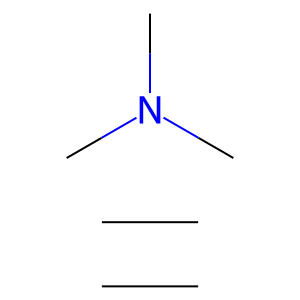

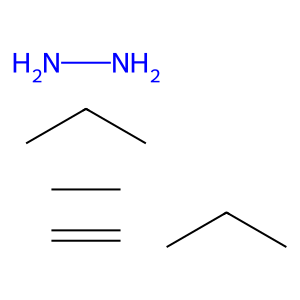

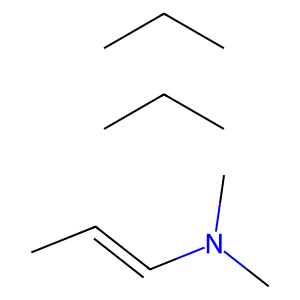

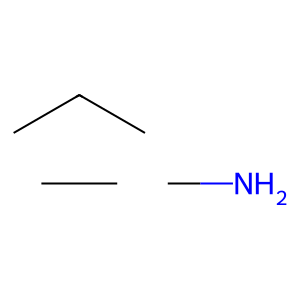

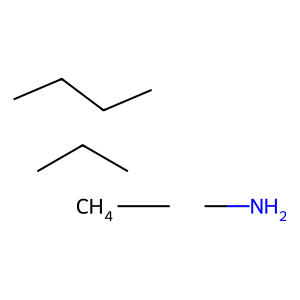

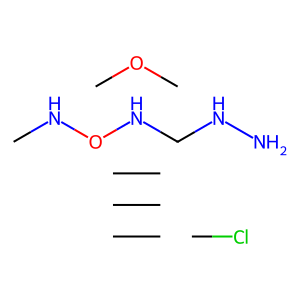

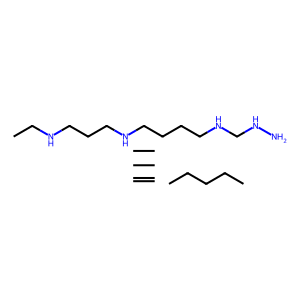

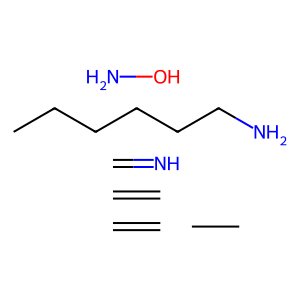

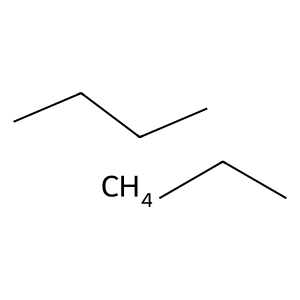

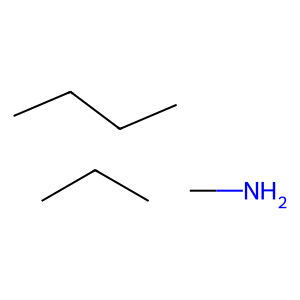

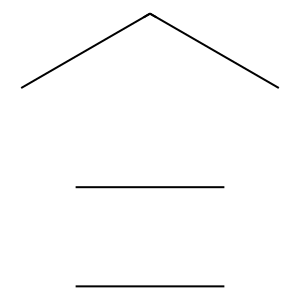

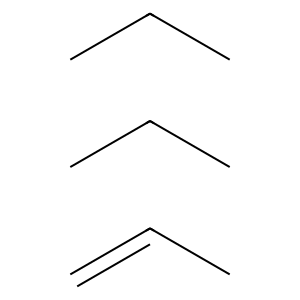

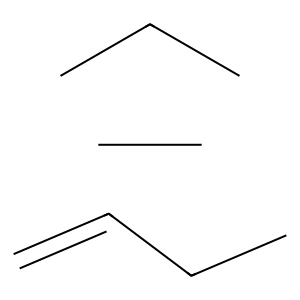

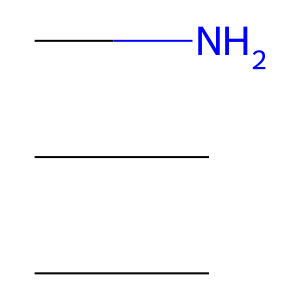

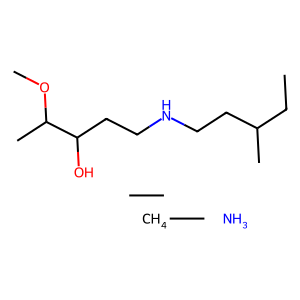

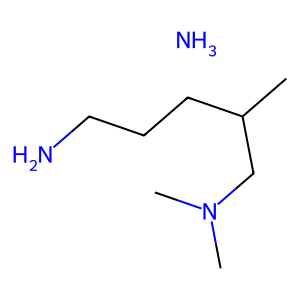

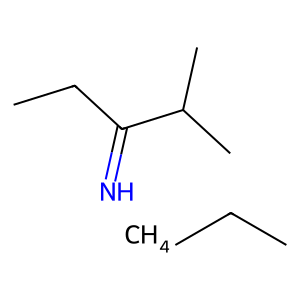

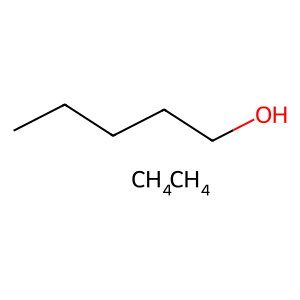

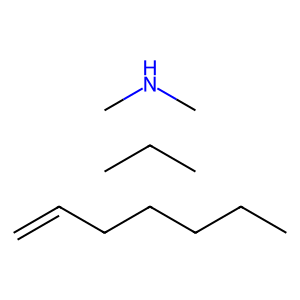

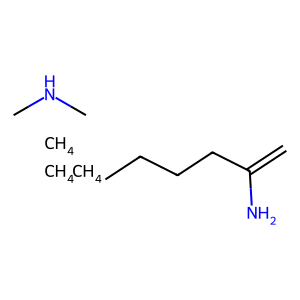

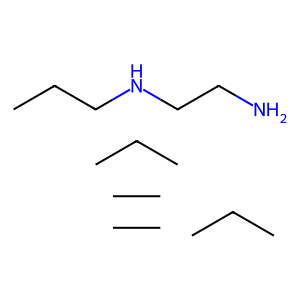

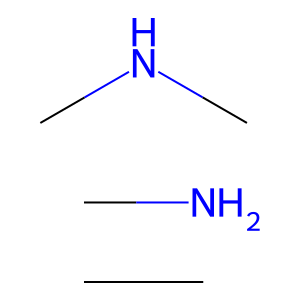

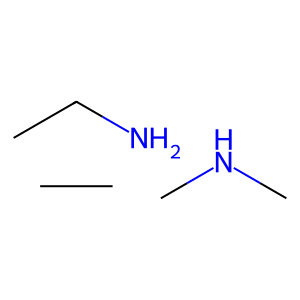

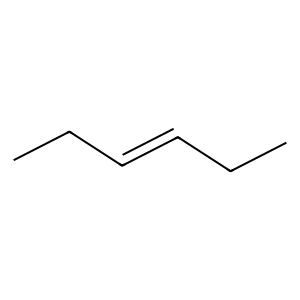

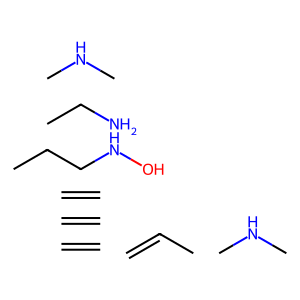

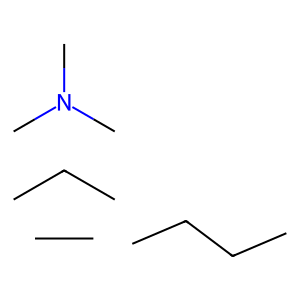

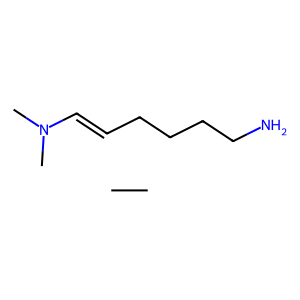

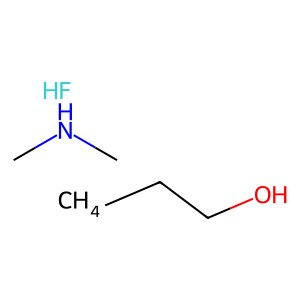

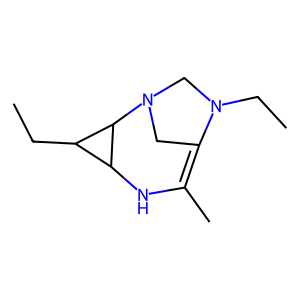

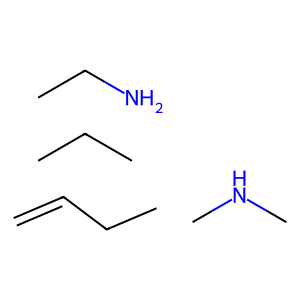

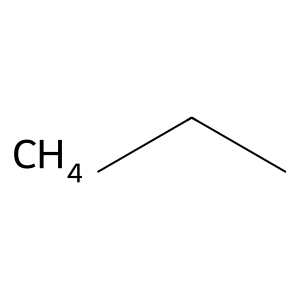

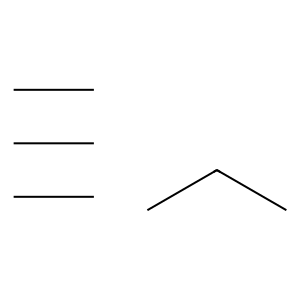

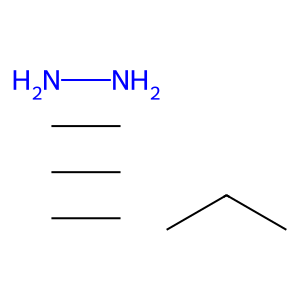

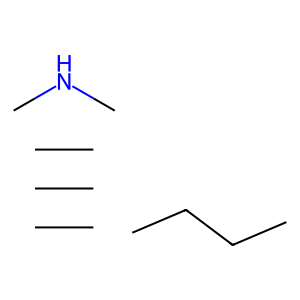

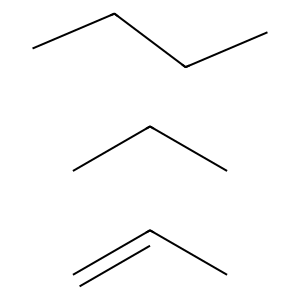

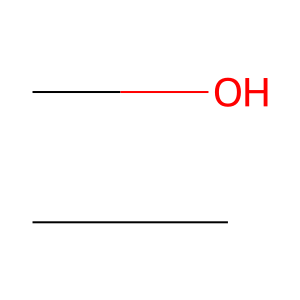

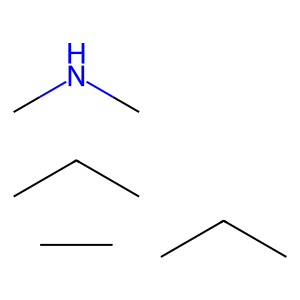

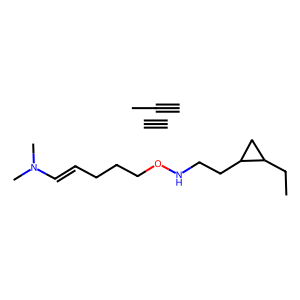

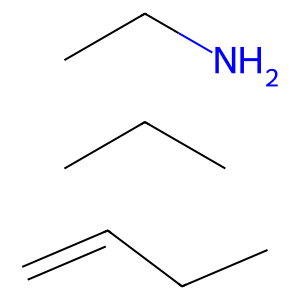

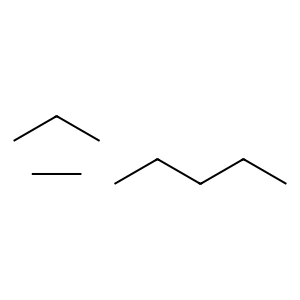

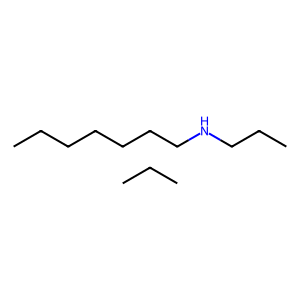

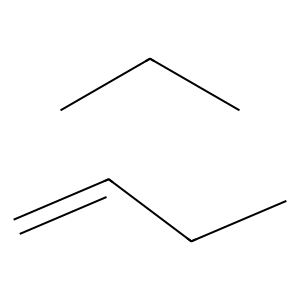

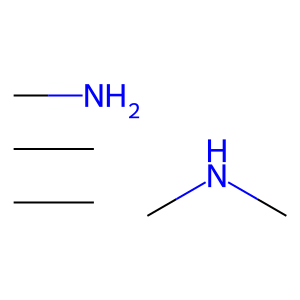

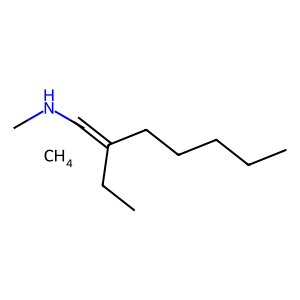

In [89]:
from IPython.display import display
for image in images:
    display(image)

C:\Users\houss\anaconda3\lib\site-packages\rdkit\Chem\Draw\IPythonConsole.py:258: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn(


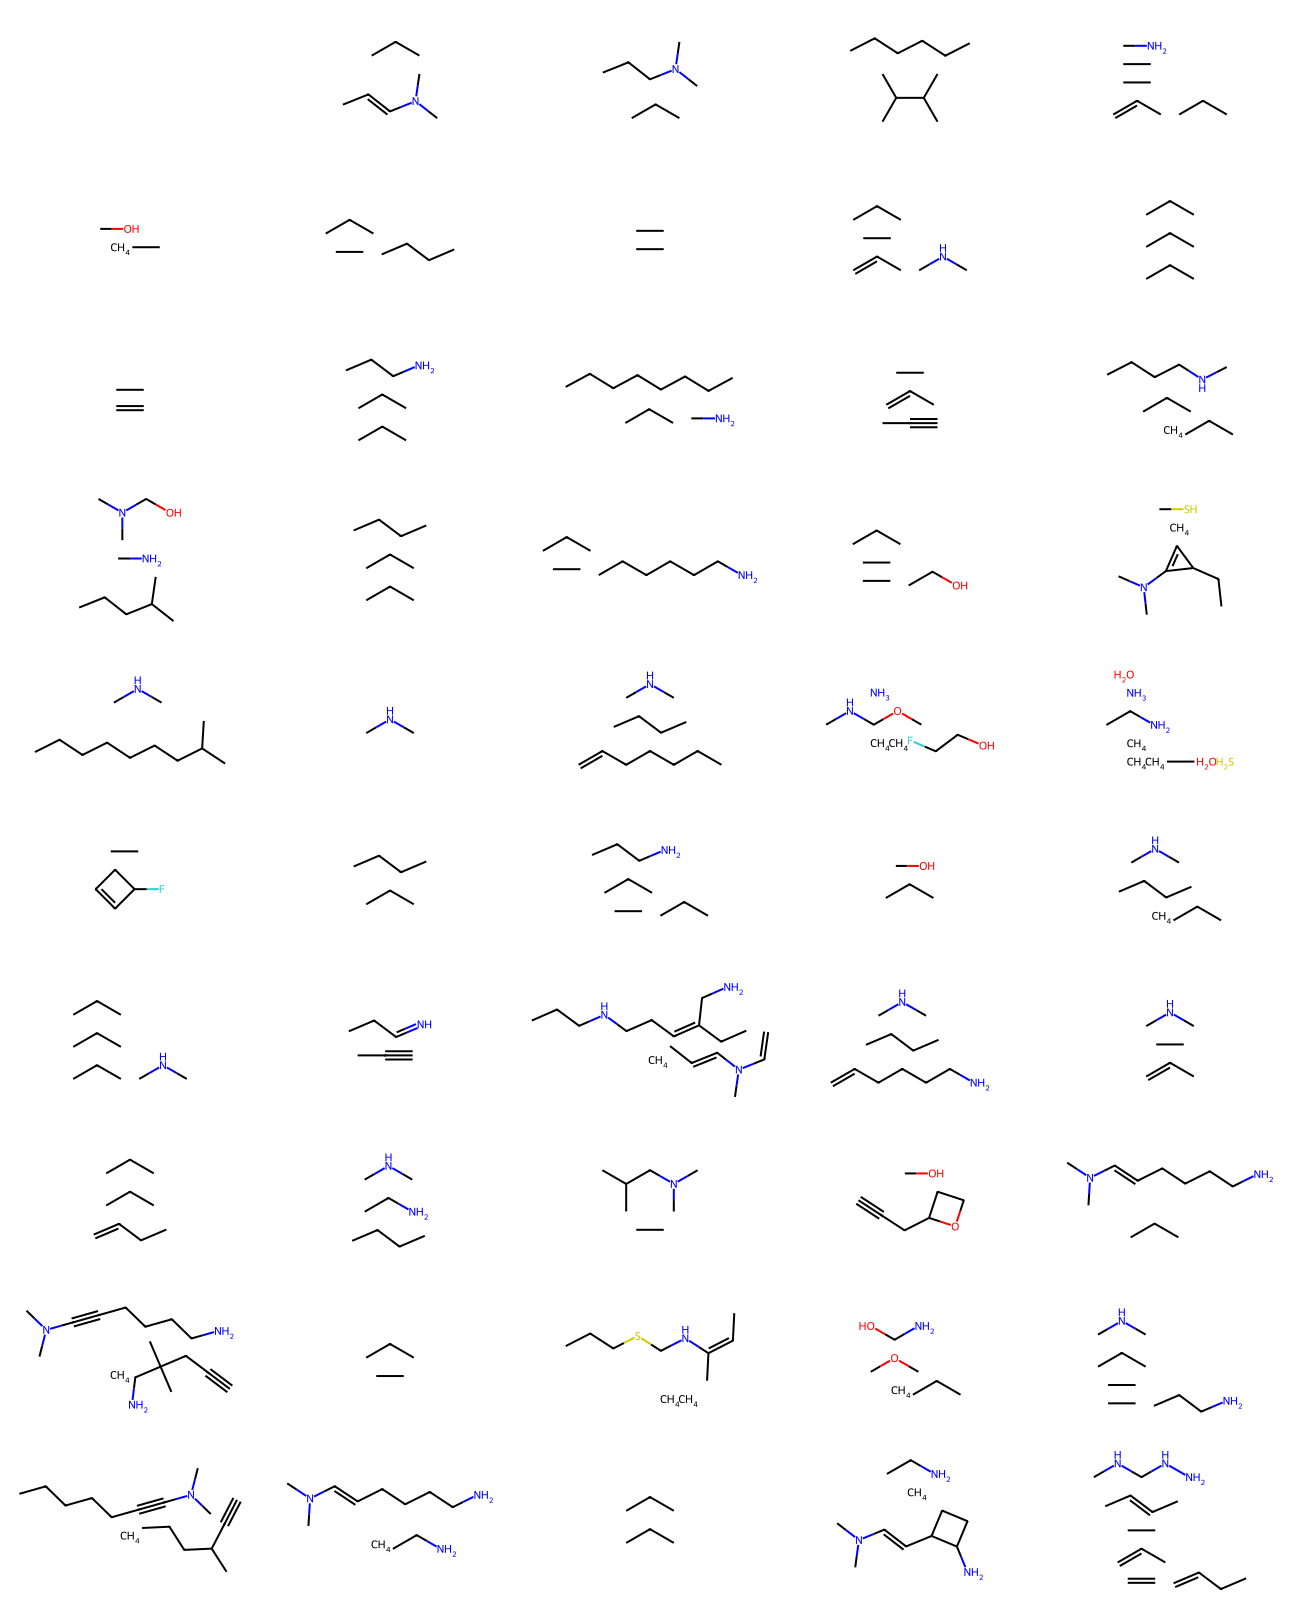

In [21]:
MolsToGridImage(
    [m for m in unique_molecules if m is not None][:850], molsPerRow=5, subImgSize=(260, 160)
)

Validation with MolVS

In [22]:
from molvs import validate_smiles
valid_smiles_list=[]

def validate_canonical_smiles(smiles):
   
    try:
        # Use MolVS library to validate the SMILES
        valid = validate_smiles(smiles)
        return valid
    except:
        # If any exception occurs during MolVS processing, return False
        return False


for smiles in unique_smiles:
    if validate_canonical_smiles(smiles):
        print(f"{smiles} is a valid canonical SMILES.")
        valid_smiles_list.append(smiles)  # Add valid SMILES to the list
    else:
        print(f"{smiles} is an invalid canonical SMILES.")

print("Valid canonical SMILES:")
print(valid_smiles_list)


 is a valid canonical SMILES.
CC=CN(C)C.CCC is an invalid canonical SMILES.
CCC.CCCN(C)C is an invalid canonical SMILES.
CC(C)C(C)C.CCCCCC is a valid canonical SMILES.
C=CC.CC.CC.CCC.CN is a valid canonical SMILES.
C.CC.CO is a valid canonical SMILES.
CC.CCC.CCCC is an invalid canonical SMILES.
CC.CC is an invalid canonical SMILES.
C=CC.CC.CCC.CNC is an invalid canonical SMILES.
CCC.CCC.CCC is an invalid canonical SMILES.
C=C.CC is an invalid canonical SMILES.
CCC.CCC.CCCN is an invalid canonical SMILES.
CCC.CCCCCCCC.CN is a valid canonical SMILES.
C#CC.C=CC.CC is an invalid canonical SMILES.
C.CCC.CCC.CCCCNC is an invalid canonical SMILES.
CCCC(C)C.CN.CN(C)CO is a valid canonical SMILES.
CCC.CCC.CCCC is an invalid canonical SMILES.
CC.CCC.CCCCCCN is an invalid canonical SMILES.
CC.CC.CCC.CCO is a valid canonical SMILES.
C.CCC1C=C1N(C)C.CS is an invalid canonical SMILES.
CCCCCCCC(C)C.CNC is an invalid canonical SMILES.
CNC is an invalid canonical SMILES.
C=CCCCCC.CCCC.CNC is an invalid

# Show Unique molecules

In [23]:
valid_smiles_list

# Convert list of string representations to set to remove duplicates
unique_molecules_smiles_set = set(valid_smiles_list)
            # Convert set back to list of string representations
unique_molecules_smiles_list = list(valid_smiles_list)

            # Convert list of string representations back to list of RWMol objects
unique_molecules1 = [Chem.MolFromSmiles(smiles) for smiles in valid_smiles_list]
unique_smiles1 = [Chem.MolToSmiles(mol) for mol in unique_molecules]

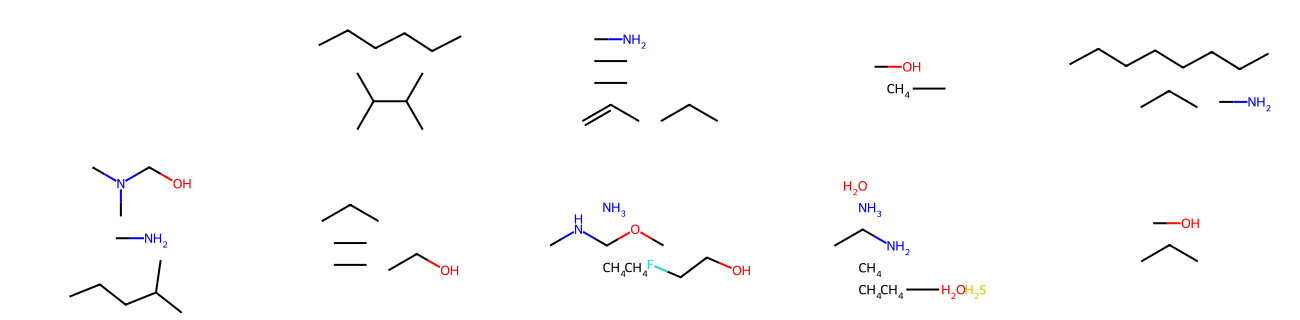

In [28]:
MolsToGridImage(
    [m for m in unique_molecules1 if m is not None][:10], molsPerRow=5, subImgSize=(260, 160)
)

### Display latent space clusters 

The code is generating a scatter plot of the latent space of a Variational Autoencoder (VAE) trained on molecular graphs, where each point in the plot represents a molecular graph and its location in the two-dimensional space is determined by the two latent variables (z[0], z[1]) learned by the VAE.

27/27 [==============================] - 2s 10ms/step


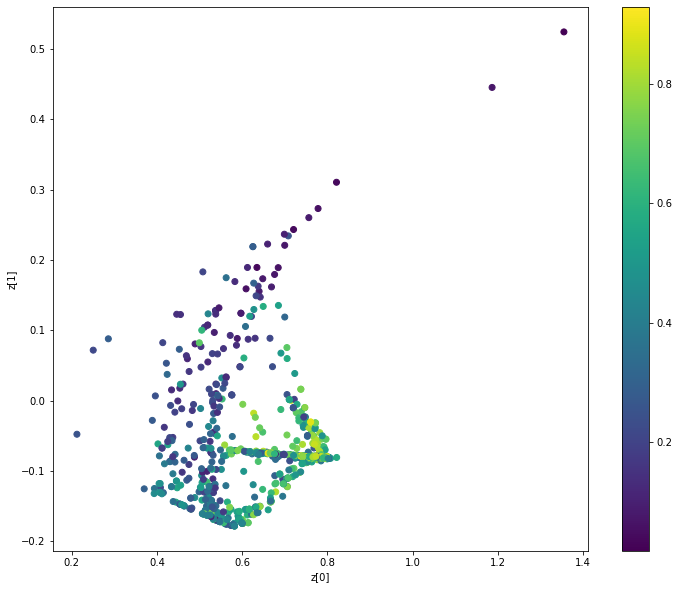

In [25]:
def plot_label_clusters(vae, data, labels):
    # display a 2D plot of the property in the latent space
    z_mean, _ = vae.encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()


train_data = DataGenerator(
                            data=train_df,
                            mapping = SMILE_to_index, 
                            max_len = NUM_ATOMS,
                            batch_size=850
                        )
x_train, y_train = next(iter(train_data))
plot_label_clusters(model, x_train, y_train)

The graph of the latent space shows the distribution of the encoded molecular properties. The x-axis represents the value of the first dimension of the encoded property, and the y-axis represents the value of the second dimension. Each point in the graph represents the encoded properties of a single molecule in the dataset. The color of the points represents the label or property associated with that molecule.

Interpreting the graph can provide insight into the structure of the dataset. If molecules with similar properties are clustered together in the graph, it indicates that the model has learned to encode the relevant features of the molecules in a way that captures the differences between different properties. Conversely, if the points are scattered randomly across the graph with no discernible patterns, it suggests that the model has not been successful in capturing the underlying structure of the dataset.

In this specific case, the graph shows the distribution of the encoded properties of a batch of molecules from the training dataset, with each color representing a different property. It is difficult to interpret the results without further context, but if molecules with similar properties are clustered together, it suggests that the model has learned to capture the relevant features of the molecules that are associated with those properties.